# Data Science in Finance mit Python - Final Case

### Michael Betz und Dennis Götz

**Aufgabenstellung für Bachelor- und Master-Studenten:**
1. Wählen Sie 15 Unternehmen aus, die bereits seit 1997 an der Börse gelistet sind. Bestimmen Sie für Ihre 15 Aktien die Portfolios mit der minimalen Varianz, dem minimalen VaR und der maximalen Sharpe Ratio. Nutzen Sie dafür Tagesdaten Ihrer 15 Aktien von 1997-2001.
2. Implementieren Sie Buy-and-Hold Strategien für Ihre drei Portfolios von 2002-2021 
auf Grundlage der errechneten Gewichte Ihrer 15 Aktien.
3. Diskutieren Sie die Performance Ihrer drei Portfolios.
4. Erstellen Sie eine Grafik für den Zeitraum 2002-2021, welche den Kursverlauf Ihrer 
drei Portfoliostrategien einem gleichgewichteten Portfolio aus den 15 Aktien als 
Benchmark gegenüberstellt.
5. Berechnen Sie die Portfolios mit der minimalen Varianz, dem minimalen VaR und der 
maximalen Sharpe Ratio nun für den Zeitraum von 2017-2021 und vergleichen Sie die 
Portfoliogewichte mit den Ihren.
6. Wie würden Sie die Implementierung Ihrer Portfoliostrategie noch verbessern? Was 
könnten Sie noch beachten?


Matrikelnummer: 272038

Name Teampartner: Betz Michael

In [1]:
# Import der notwendigen Bibliotheken
import pandas as pd
import numpy as np
import pandas_datareader.data as web
from datetime import datetime
import scipy.optimize as sco
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import yfinance as yf
from IPython.display import HTML

# Aktienauswahl nach minimaler Kovarianz

Aufgabenstellung: Wählen Sie 15 Unternehmen aus, die bereits seit 1997 an der Börse gelistet sind. Bestimmen Sie für Ihre 15 Aktien die Portfolios mit der **minimalen Varianz**, dem **minimalen VaR** und der **maximalen Sharpe Ratio**. Nutzen Sie dafür Tagesdaten Ihrer 15 Aktien von 1997-2001.

In [2]:
yf.pdr_override()
tickers = ['AAPL', 'ABC', 'ABT', 'ADBE', 'ADM', 'ADP', 'ADSK', 'AEP', 'AIR',
       'AMD', 'AMGN', 'ATVI', 'AXP', 'AZN', 'BA', 'BAX', 'BCE', 'BMY',
       'BSX', 'BTI', 'C', 'CAT', 'CHD', 'CL', 'CLX', 'CMCSA', 'COST',
       'CSCO', 'CVS', 'DD', 'DE', 'DIS', 'DTE', 'DUK', 'DVN', 'EA', 'ED',
       'EFX', 'EMR', 'ETN', 'F', 'FCX', 'FDX', 'FISV', 'GD', 'GE', 'GIS',
       'HAL', 'HD', 'HOG', 'HON', 'HRL', 'HSIC', 'HTHIY', 'HUM', 'IBM',
       'INTC', 'INTU', 'IP', 'ITW', 'JNJ', 'JPM', 'K', 'KO', 'LLY', 'LMT',
       'LUV', 'MCD', 'MDT', 'MMM', 'MO', 'MRK', 'MSFT', 'NKE', 'NVO',
       'NYT', 'OMC', 'ORCL', 'PCRFY', 'PEP', 'PFE', 'PG', 'PHG', 'RELX',
       'RTX', 'SAP', 'SBUX', 'SCHW', 'SLB', 'SO', 'SONY', 'T', 'TJX',
       'TM', 'TRV', 'TXN', 'UL', 'VOD', 'VZ', 'WBA', 'WHR', 'WM', 'WMT',
       'WPP', 'XOM']
start = '1997-01-01'
end = '2021-12-31'

# DataFrame mit den Adj Close Preisen der Ticker erstellen
Adj_Close = web.get_data_yahoo(tickers, start, end)['Adj Close']
Adj_Close = pd.DataFrame(Adj_Close)

# Anzahl fehlender Werte sollte 0 sein
print(Adj_Close.isna().sum().sum())

# Logreturns berechnen
returns = np.log(Adj_Close/Adj_Close.shift(1))
returns = returns.dropna()

[*********************100%***********************]  105 of 105 completed
0


In [3]:
# Dataframe kürzen 1997-2001
insample = returns.loc['1997-01-01':'2001-12-31']

# Varianz-Covarianz-Matrix berechnen
cov_matrix = insample.cov()

# Varianzen löschen (Hauptdiagonale = 0)
for i in range(len(cov_matrix)):
    cov_matrix.iloc[i,i] = 0

In [4]:
# Minimierung der Summe der Covarianzen im Portfolio
# Funktion 1
def calc_min_covariance(selected_assets, num_assets, cov_matrix):
    covariances = selected_assets * cov_matrix #slected_assets als freie Variable (alle möglichen 15-Asset-Portfolios) * Covarianz-Matrix aller Assets -> Covarianz-Matrix des aktuell betrachteten Portfolios
    portfolio_covariance = np.sum(np.sum(covariances)) #Summe der Portfolio-Covarianz
    return portfolio_covariance

# Funktion 2
def min_port_covariance(num_assets, cov_matrix):
    args = (num_assets, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - num_assets})
    start = np.concatenate((np.ones(num_assets), np.zeros(len(tickers) - num_assets)), axis=0)
    bound = (0, 1)
    bounds = tuple(bound for asset in range(len(tickers)))
    result = sco.minimize(calc_min_covariance, start, args=args, 
                          method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# Ausführen der Funktionen und runden der Gewichtungen auf 0 bzw. 1
selected_assets = np.round(min_port_covariance(15, cov_matrix))
selected_assets

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1.])

In [5]:
# Min Covariance Portfolio aus allen Tickern extrahieren
tickers_np = np.array(tickers)
portfolio_tickers = tickers_np[selected_assets==1].tolist()
print(portfolio_tickers)
len(portfolio_tickers)

['AEP', 'AZN', 'BTI', 'DTE', 'DUK', 'DVN', 'ED', 'FCX', 'GIS', 'HRL', 'LMT', 'NVO', 'RELX', 'SO', 'XOM']


15

In [6]:
# Summe der Covariancen des Portfolios berechnen und mit Beispielportfolios vergleichen
#portfolio_returns = insample[0:15] #ersten 15 Aktien
#portfolio_returns = insample[40:55]
#portfolio_returns = insample[90:105]
portfolio_returns = insample[portfolio_tickers] #Min Covariance Portfolio
portfolio_cov = portfolio_returns.cov()

# Varianzen löschen (Hauptdiagonale = 0)
for i in range(len(portfolio_cov)):
    portfolio_cov.iloc[i,i] = 0

# Summe der Covarianzen im Portfolio
portfolio_covariance = np.sum(np.sum(portfolio_cov))
print(portfolio_covariance)

0.010313804569918874


| Ticker | Unternehmensname |
| :--- | :--- |
| AEP | American Electric Power Company, Inc |
| AZN | AstraZeneca PLC |
| BTI | British American Tobacco PLC |
| DTE | Deutsche Telekom AG |
| DUK | Duke Energy Corp. |
| DVN | Devon Energy Corp. |
| ED | Consolidated Edison, Inc. |
| FCX | Freeport-McMoRan, Inc. |
| GIS | General Mills, Inc. |
| HRL | Hormel Foods Corp. |
| LMT | Lockheed Martin Corp. |
| NVO | Novo Nordisk A/S |
| RELX | Relx PLC |
| SO | Southern Company |
| XOM | Exxon Mobil Corp |

# Erstellung des Portfolios

In [7]:
tickers = ['AEP', 'AZN', 'BTI', 'DTE', 'DUK', 'DVN', 'ED', 'FCX', 'GIS', 
           'HRL', 'LMT', 'NVO', 'RELX', 'SO', 'XOM']
start = '1997-01-01'
end = '2021-12-31'

# DataFrame mit den Adj Close Preisen der Ticker erstellen
Adj_Close = web.get_data_yahoo(tickers, start, end)['Adj Close']
Adj_Close = pd.DataFrame(Adj_Close)

[*********************100%***********************]  15 of 15 completed


In [8]:
# Berechnung der Logrenditen (Vorteil der Additivität)
returns = pd.DataFrame(np.diff(np.log(Adj_Close).T).T)
returns.index = Adj_Close.index[1:]
returns.columns = tickers

In [9]:
# Portfolioübersicht
# annual mean returns and annual return variances
annual_mean_returns = returns.mean() * 252
annual_return_variance = returns.var() * 252

# New dataframe
df2 = pd.DataFrame(Adj_Close.columns, columns=['Ticker'])
df2['annual Variance'] = annual_return_variance.values
df2['annual Return'] = annual_mean_returns.values
df2

,Ticker,annual Variance,annual Return
0,AEP,0.058033,0.076624
1,AZN,0.074531,0.093571
2,BTI,0.081837,0.113711
3,DTE,0.048356,0.103791
4,DUK,0.057653,0.084663
5,DVN,0.187258,0.050154
6,ED,0.038626,0.091185
7,FCX,0.272712,0.061929
8,GIS,0.037528,0.088058
9,HRL,0.055006,0.125626


# 1. Portfolios mit min. Varianz, min. VaR und max. Sharpe Ratio (1997-2001)

In [10]:
# DataFrame auf den Zeitraum des Kalibrationsdatensatzes von 1997/01/01 - 2001/12/31 begrenzen
insample = returns.loc['1997-01-01':'2001-12-31']



Berechnung der notwendigen Eingabeparameter für die anschließenden Funktionen.

Annahme: Festlegung des risikolosen Zinsatzes auf 0%.

In [11]:
# Berechnung der Varianz-Covarianz-Matrix, mittleren Renditen und Festlegung von Alpha-Quantil, Zeithorizont und risikolosem Zins
insample_cov = insample.cov() 
insample_mean_returns = insample.mean()
alpha = 0.05
days = 252
rf = 0 

Erzeugung der **Korrelationsmatrix** des Portfolios. Daraus kann abgelesen werden, dass die gewählten Aktien
des Portfolios nur in geringem Maß miteinander korrelieren, da die Korrelationskoeffizienten niedrige Werte aufweisen.

Das Ziel ist ein diversifiziertes Portfolio aus Aktien. 

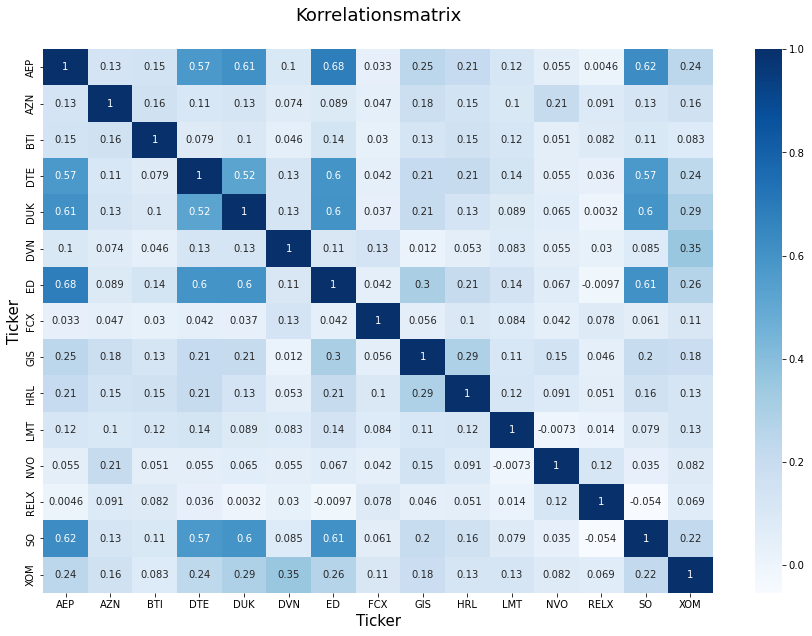

In [12]:
# Bildung der Correlationsmatrix der AKtien für 1997-2001
plt.figure(figsize=(15,10))
sns.heatmap(insample.corr(), cmap="Blues", annot=True)
plt.title('Korrelationsmatrix', fontsize = 18, va = 'center', y = 1.05)
plt.xlabel('Ticker', fontsize = 15)
plt.ylabel('Ticker', fontsize = 15);

### 1.1 Bestimmung des Portfolios mit minimaler Varianz (1997-2001)

Zur Bestimmung des Portfolios entscheiden wir uns für die **Numerische Optimierung**, da diese genauer ist als die Monte-Carlo-Simulation, welche sich nur an das Miniumum/Maximum annähert.

**Funktion 1** berechnet die annualisierte Standardabweichung $𝜎=h^{T}Vh$ des Portfolios und übergibt diese an die Minimierungsfunktion in **Funktion 2**.

Die **Nebenbedingung** stellt sicher, dass die Summe der Gewichte im Portfolio gleich 1 ist.

In [13]:
# Funktion 1
def calc_portfolio_std(weights, cov):
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(252) #h=15x1 Matrix-> [h.transpose * cov] * h = [1x15 * 15x15] * 15x1 = 1x15 * 15x1 = 1x1
    return portfolio_std

# Funktion 2
def min_variance(cov):
    num_assets = len(cov)
    args = cov
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}) #Nebenbedingung; ; eq für equality -> Gleichung != 0; np.sum(weights) - 1 = 0 (Summe der Gewichte müssen 1 ergeben und Gleichung muss gleich Null sein!)
    bound = (0.0, 1.0)
    bounds = tuple(bound for assets in range(num_assets))
    result = sco.minimize(calc_portfolio_std, num_assets*[1/num_assets], args=args, 
                         method='SLSQP', bounds=bounds, constraints=constraints)
    return result

# Ausführen der Funktionen
function_result = min_variance(insample_cov) #fun: gibt den ZF-wert (Min Varinaz) an & x: gibt die Gewichtungen der einzelnen Aktien im Portfolio an

# Ergebnisse der Optimierung in DataFrame abspeichern
insample_min_port_variance = pd.DataFrame([round(x,2) for x in function_result['x']], index=tickers).T #Gewichte auf 2 Nachkommastellen runden
insample_min_port_variance['Function Result'] = function_result['fun'] #Spalte für Zielfunktionswert

In [14]:
# Funktion zur Bestimmung der Standardabweichung, Sharpe-Ratio und des Value-at-Risk
def calc_portfolio_perf(weights, mean_returns, cov, alpha, days):
    portfolio_return = np.sum(mean_returns * weights) * days
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(days)
    portfolio_VaR = abs(portfolio_return - (portfolio_std * stats.norm.ppf(1 - alpha)))
    sharpe_ratio = (portfolio_return) / portfolio_std
    return portfolio_return, portfolio_std, portfolio_VaR, sharpe_ratio

In [15]:
# Berechnung der weiteren Kennzahlen Rendite, Standardabweichung, Sharpe Ratio, Value at Risk für das min_variance_portfolio

# Entfernung der 'Function Result'- Spalte
insample_min_port_variance1 = insample_min_port_variance.drop(columns = ['Function Result'], axis = 1)

# Verwendung der exakten Gewichte zur Berechnung
insample_min_port_variance_weights = pd.DataFrame([round(x,6) for x in function_result['x']], index=tickers).T
weights1 = np.array(insample_min_port_variance_weights.iloc[0])

# Berechnung der Parameter
portfolio_return, portfolio_std, portfolio_VaR, sharpe_ratio = calc_portfolio_perf(weights1, insample_mean_returns, insample_cov, alpha, days)

# Erstellung einer Funktion zum Hinzufügen der neuen Werte als Spalten
def add_values(dataframe):
    dataframe.insert(loc=0, column='Annual Return', value=portfolio_return)
    dataframe.insert(loc=1, column='Annual Variance', value=portfolio_std)
    dataframe.insert(loc=2, column='Value at Risk', value=portfolio_VaR)
    dataframe.insert(loc=3, column='Sharpe Ratio', value=sharpe_ratio)
    
# Ausführung der Funktion
add_values(insample_min_port_variance1)

# Rename des Index
insample_min_port_variance1.index = ['Min_variance']

### 1.2 Bestimmung des Portfolios mit minimalem Value at Risk (VaR) (1997-2001)

**Funktion 1** berechnet die annualisierten Mean Returns 𝜇, die annualisierte Standardabweichung $𝜎=h^{T}Vh$ und den Value at Risk des Portfolios und gibt den VaR aus, damit dieser von der Minimierungsfunktion in **Funktion 2** minimiert werden kann.

In [16]:
# Funktion 1
def calc_portfolio_VaR(weights, mean_returns, cov, alpha, days):
    portfolio_return = np.sum(weights * mean_returns) * days #nur bei Logrenditen Addition möglich
    portfolio_std = np.sqrt(np.dot(np.dot(weights.T, cov), weights)) * np.sqrt(days)
    portfolio_VaR = abs(portfolio_return - (portfolio_std * stats.norm.ppf(1 - alpha))) #Erklären
    return portfolio_VaR

# Funktion 2
def min_VaR(mean_returns, cov, alpha, days):
    num_assets = len(mean_returns)
    args = (mean_returns, cov, alpha ,days)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0, 1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(calc_portfolio_VaR, num_assets*[1/num_assets], args=args, 
                         method='SLSQP', bounds=bounds, constraints=constraints)
    return result

# Ausführen der Funktionen
function_result = min_VaR(insample_mean_returns, insample_cov, alpha, days)

# Ergebnisse der Optimierung in DataFrame abspeichern
insample_min_port_VaR = pd.DataFrame([round(x,2) for x in function_result['x']], index=tickers).T
insample_min_port_VaR['Function Result'] = function_result['fun']

In [17]:
# Berechnung der weiteren Kennzahlen Rendite, Standardabweichung, Sharpe Ratio, Value at Risk für das min_VaR_portfolio
insample_min_port_VaR1 = insample_min_port_VaR.drop(columns = ['Function Result'], axis = 1)
insample_min_port_VaR_weights = pd.DataFrame([round(x,6) for x in function_result['x']], index=tickers).T
weights2 = np.array(insample_min_port_VaR_weights.iloc[0])
portfolio_return, portfolio_std, portfolio_VaR, sharpe_ratio = calc_portfolio_perf(weights2, insample_mean_returns, insample_cov, alpha, days)
add_values(insample_min_port_VaR1)
insample_min_port_VaR1.index = ['Min_VaR']

### 1.3 Bestimmung des Portfolios mit maximaler Sharpe Ratio (𝜇 - 𝜎 effizientes Portfolio) (1997-2001)
 
 

**Funktion 1** berechnet die annualisierten Mean Returns 𝜇, die annualisierte Standardabweichung $𝜎=h^{T}Vh$ und die Sharpe-Ratio (𝜇 - rf) / 𝜎 des Portfolios und gibt die negative Sharpe Ratio aus, damit diese von der Minimierungsfunktion in **Funktion 2** maximiert werden kann.

In [18]:
# Funktion 1
def calc_neg_sharpe(weights, mean_returns, cov, rf):
    portfolio_return = np.sum(weights * mean_returns) * 252
    portfolio_std = np.sqrt(np.dot(np.dot(weights.T, cov), weights)) * np.sqrt(252)
    sharpe_ratio = (portfolio_return - rf) / portfolio_std
    return -sharpe_ratio

# Funktion 2
def max_sharpe_ratio(mean_returns, cov, rf):
    num_assets = len(mean_returns)
    args = (mean_returns, cov, rf)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) -1})
    bound = (0.0, 1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(calc_neg_sharpe, num_assets*[1/num_assets], args=args, 
                          method='SLSQP', bounds=bounds, constraints=constraints)
    return result

# Ausführen der Funktionen
function_result = max_sharpe_ratio(insample_mean_returns, insample_cov, rf)

# Ergebnisse der Optimierung in DataFrame abspeichern
insample_max_port_sharpeRatio = pd.DataFrame([round(x,2) for x in function_result['x']], index=tickers).T
insample_max_port_sharpeRatio['Function Result'] = -function_result['fun'] #hier Vorzeichen wieder umkehren!

In [19]:
# Berechnung der weiteren Kennzahlen Rendite, Standardabweichung, Sharpe Ratio, Value at Risk für das max_sharpeRatio_portfolio
insample_max_port_sharpeRatio1 = insample_max_port_sharpeRatio.drop(columns = ['Function Result'], axis = 1)
insample_max_port_sharpeRatio_weights = pd.DataFrame([round(x,6) for x in function_result['x']], index=tickers).T
weights3 = np.array(insample_max_port_sharpeRatio_weights.iloc[0])
portfolio_return, portfolio_std, portfolio_VaR, sharpe_ratio = calc_portfolio_perf(weights3, insample_mean_returns, insample_cov, alpha, days)
add_values(insample_max_port_sharpeRatio1)
insample_max_port_sharpeRatio1.index = ['Max Sharpe Ratio']


### 1.4 Vergleich der Gewichtungen der drei Strategien (1997-2001)

In [20]:
# Zusammenfassung der Portfolios in einem DataFrame
insample_portfolios = pd.concat([insample_min_port_variance1, insample_min_port_VaR1, insample_max_port_sharpeRatio1], axis=0)
insample_portfolios.index = ['Min Variance (1997-2001)', 'Min VaR (1997-2001)', 'Max Sharpe Ratio (1997-2001)']
insample_portfolios.iloc[:, : 4]

,Annual Return,Annual Variance,Value at Risk,Sharpe Ratio
Min Variance (1997-2001),0.099907,0.128896,0.112108,0.775100
Min VaR (1997-2001),0.142117,0.139801,0.087836,1.016561
Max Sharpe Ratio (1997-2001),0.153222,0.147814,0.089910,1.036590


In [21]:
# Dataframe ausschließlich mit Gewichtungen der Aktien
insample_weights = insample_portfolios.drop(['Annual Return', 'Annual Variance', 'Sharpe Ratio', 'Value at Risk'], axis=1)

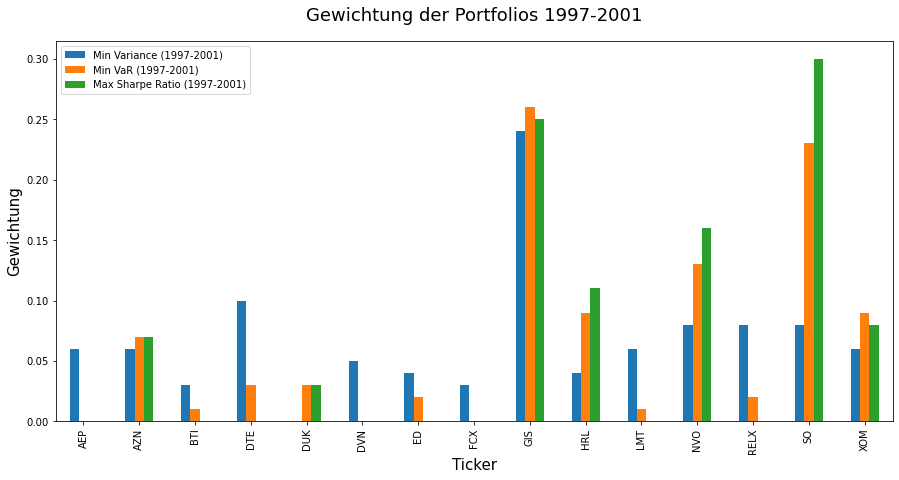

In [22]:
# Graphische Datstellung der Gewichtung der einzelnen Aktien in den drei definierten Portfolios 1997-2001
insample_weights.T.plot(kind='bar', figsize=(15,7));
plt.title("Gewichtung der Portfolios 1997-2001", fontsize = 18, va = 'center', y = 1.05)
plt.ylabel('Gewichtung', fontsize = 15);
plt.xlabel('Ticker', fontsize = 15);

**Beschreibung**:

Die Aktie mit der höchsten Gewichtung in einem Portfolio ist Southern Company mit 30% im Portfolio Max Sharpe Ratio. In Min Variance hingegen liegt der Anteil der Aktie lediglich bei 8%.

Ebenso wird deutlich, dass die Gewichtungen des Min VaR und des Max Sharpe Ratio Portfolios sehr ähnlich sind. Dies ist aber aufgrund der oben bereits beschriebenen Berechnungsmethode des Value at Risk erwartbar. Der VaR sinkt, wenn die Portfoliorenditen steigen und gleichzeitig steigt die Sharpe Ratio, wenn die Portfoliorenditen sinken.
Wirft man nun einen Blick auf die ebenso errechneten Funktionswerte der Portfolios wird auch da die Ähnlichkeit der Werte ersichtlich.

Ebenso erwähnenswert ist, dass die Aktie von General Mills (GIS) in jedem der berechneten optimalen Portfolios mit circa 25% gewichtet wird.

Das Portfolio mit minimaler Varianz gewichtet fast jede Aktie zu einem gewissen Teil. Das Value at Risk Portfolio hingegen verzichtet auf drei Titel und das Sharpe Ratio Portfolio sogar auf acht Aktien vollständig. Dies kann zu Schwierigkeiten führen, da die Performance des Portfolios lediglich auf einigen wenigen Aktien basiert. Kommt es zum Einbruch einer stark gewichteten Aktie hat das drastische Auswirkungen auf die Gesamtperformance. Ebenso kann sich dieser Effekt aber auch in die andere Richtung auswirken.


# 2. Buy-and-Hold Strategien (BaH) (2002-2021)

Aufgabenstellung: Implementieren Sie Buy-and-Hold Strategien für Ihre drei Portfolios von 2002-2021 
auf Grundlage der errechneten Gewichte Ihrer 15 Aktien. 

In [23]:
# DataFrame auf den Zeitraum des Testdatensatzes von 2002/01/01 - 2021/12/31 begrenzen
outsample = returns.loc['2002-01-01':'2021-12-31']

In [24]:
# Wiederholung
outsample_mean_returns = outsample.mean()
outsample_cov = outsample.cov()
alpha = 0.05
days = 252
rf = 0

In [25]:
# BaH-Strategie mit minimum Variance Portfolio
BaH_min_variance = insample_weights.iloc[0] * outsample #Array mit Gewichtungen * Outsample Datensatz
BaH_min_variance['Strategy'] = np.sum(BaH_min_variance, axis=1)
BaH_min_variance['Strategy Equity'] = BaH_min_variance['Strategy'].cumsum() + 1

# BaH-Strategie mit minimun VaR Portfolio
BaH_min_VaR = insample_weights.iloc[1] * outsample
BaH_min_VaR['Strategy'] = np.sum(BaH_min_VaR, axis=1)
BaH_min_VaR['Strategy Equity'] = BaH_min_VaR['Strategy'].cumsum() + 1

# BaH-Strategie mit maximum Sharpe Ratio Portfolio
BaH_max_SharpeRatio = insample_weights.iloc[2] * outsample
BaH_max_SharpeRatio['Strategy'] = np.sum(BaH_max_SharpeRatio, axis=1)
BaH_max_SharpeRatio['Strategy Equity'] = BaH_max_SharpeRatio['Strategy'].cumsum() + 1

# 3. Diskussion der Portfolio-Performances 

Aufgabenstellung: Diskutieren Sie die Performance Ihrer drei Portfolios.

In [26]:
# Kumulierte und Annualisierte Returns der Strategien berechnen
BaH_returns = pd.DataFrame(columns = ['Min Variance', 'Min VaR', 'Max Sharpe Ratio'], index=['Returns'])
BaH_returns.loc['Returns'] = [np.sum(insample_weights.iloc[i] * outsample, axis=1).cumsum()[-1] + 1 for i in range(len(insample_weights))]
BaH_returns.loc['Annual Returns'] = [np.sum(insample_weights.iloc[i] * outsample, axis=1).mean() * 252 for i in range(len(insample_weights))]
BaH_returns.T

,Returns,Annual Returns
Min Variance,2.951664,0.09768
Min VaR,2.974308,0.098813
Max Sharpe Ratio,3.056484,0.102926


In [27]:
# Übersicht der Funktionswerte der Buy and Hold Strategie (BaH) 2002-2021

# Min Variance Portfolio 2002-2021
portfolio_return, portfolio_std, portfolio_VaR, sharpe_ratio = calc_portfolio_perf(weights1, outsample_mean_returns, outsample_cov, alpha, days)
df2 = [portfolio_return, portfolio_std, portfolio_VaR, sharpe_ratio]
df2 = pd.DataFrame(df2).T
df2.columns = ['Annual Return', 'Annual Variance', 'Value at Risk', 'Sharpe Ratio']
df2.index = ['Min Variance (2002-2021)']

# Min Value at Risk Portfolio 2002-2021
a = [portfolio_return, portfolio_std, portfolio_VaR, sharpe_ratio] = calc_portfolio_perf(weights2, outsample_mean_returns, outsample_cov, alpha, days)
df2. loc['Min VaR (2002-2021)'] = a

# Max Sharpe Ratio Portfolio 2002-2021
b = [portfolio_return, portfolio_std, portfolio_VaR, sharpe_ratio] = calc_portfolio_perf(weights3, outsample_mean_returns, outsample_cov, alpha, days)
df2. loc['Max Sharpe Ratio (2002-2021)'] = b

In [28]:
# Funktion zum Vergleich der Funktionswerte der Portfolios der Zeiträume 1997-2001 und 2002-2021
def parallel(*dfs):
    html = '<div style="display:flex">'
    for df in dfs:
        html += '<div style="margin-right: 2em">'
        html += df.to_html()
        html += '</div>'
    html += '</div>'
    display(HTML(html))

# Vergleich der Funktionswerte der Portfolios der Zeiträume 1997-2001 und 2002-2021    
parallel(insample_portfolios.iloc[:, : 4],df2)

,Annual Return,Annual Variance,Value at Risk,Sharpe Ratio
Min Variance (1997-2001),0.099907,0.128896,0.112108,0.775100
Min VaR (1997-2001),0.142117,0.139801,0.087836,1.016561
Max Sharpe Ratio (1997-2001),0.153222,0.147814,0.089910,1.036590
,Annual Return,Annual Variance,Value at Risk,Sharpe Ratio
Min Variance (2002-2021),0.097154,0.155069,0.157911,0.626523
Min VaR (2002-2021),0.099953,0.147464,0.142603,0.677815
Max Sharpe Ratio (2002-2021),0.102592,0.148510,0.141686,0.690806


**Beschreibung:**

Bei der Betrachtung der Funktionswerte beider Tabellen ist deutlich zu erkennen, dass nach der Implementierung der Buy and Hold Strategie die Performance der Portfolios abgenommen hat. 
Die Renditen sind gesunken. Die Varianz und der Value at Risk gestiegen und die Sharpe Ratio erlitt einen deutlichen Rückgang.

In [29]:
# Einführung des S&P500 als Benchmark 
SP500 = web.get_data_yahoo('^GSPC', datetime(2002,1,1), datetime(2021,12,31))
SP500_returns = pd.DataFrame(np.diff(np.log(SP500['Adj Close'].values)))
SP500_returns.index = SP500.index.values[1:SP500.index.values.shape[0]]
SP500_returns.columns = ['S&P500 Returns']
SP500_returns['Strategy'] = np.sum(SP500_returns, axis=1)
SP500_returns['Strategy Equity'] = SP500_returns['Strategy'].cumsum() + 1

[*********************100%***********************]  1 of 1 completed


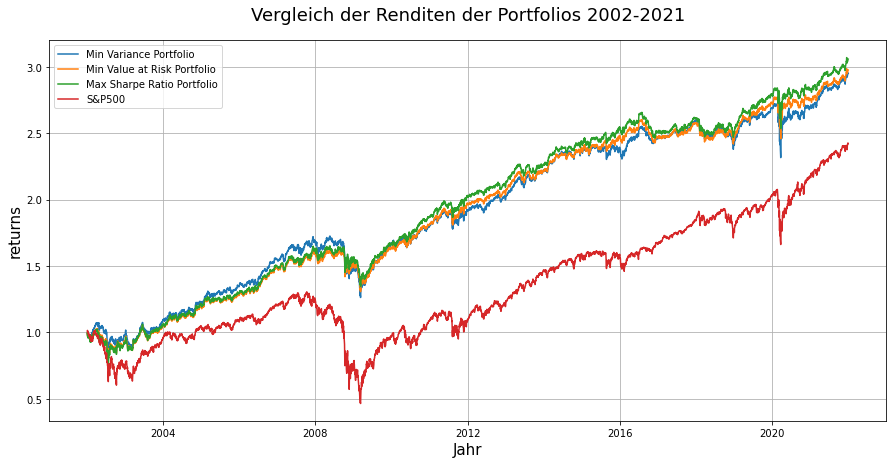

In [30]:
# Plot der kummulierten Returns
plt.figure(figsize=(15,7))
plt.plot(BaH_min_variance['Strategy Equity'], label = 'Min Variance Portfolio')
plt.plot(BaH_min_VaR['Strategy Equity'], label = 'Min Value at Risk Portfolio')
plt.plot(BaH_max_SharpeRatio['Strategy Equity'], label = 'Max Sharpe Ratio Portfolio')
plt.plot(SP500_returns['Strategy Equity'], label = 'S&P500');
plt.title('Vergleich der Renditen der Portfolios 2002-2021', fontsize = 18, va = 'center', y = 1.05)
plt.xlabel('Jahr', fontsize = 15)
plt.ylabel('returns', fontsize = 15)
plt.grid()
plt.legend();

**Beschreibung:**

Das Liniendiagramm zeigt den Verlauf der kummulierten Rendite der Portfolios mit den durch numerische Optimierung bestimmten Gewichten. Sieht man sich jedoch nun die graphische Entwicklung der kummulierten Renditen im Zeitverlauf an, wird deutlich, dass die Portfolios zwar nicht so gut performen wie 1997-2001, aber deutlich besser als die Benchmark S&P500 im besagten Zeitraum.
Das best performende Portfolio ist das Max Sharpe Ratio Portfolio. Hier ist zum Jahresende 2021 die erwirtschaftete Rendite am höchsten. <br>
Danach kommt das Min Value at Risk Portfolio dicht gefolgt vom Min Variance Portfolio. Diese beiden Portfolios unterscheiden sich am Ende aber nur geringfügig.<br>
Generell kann gesagt werden, dass sich die Overall Performance der drei Portfolios doch sehr ähnelt. Dies kann auch darauf zurückgeführt werden, dass bei der Auswahl der Aktien auf eine geringe Varianz bzw. Volatilität geachtet wurde. Ein Blick auf die Branchen der stärker gewichteten Aktien wie General Mills (Lebensmittelbranche) zeigt, dass diese nicht zu  risikoreicheren Branchen wie Bio-/Technologie zählen.

Hier sieht man gut, dass Aktien zwar untereinander nicht sonderlich stark korreliert sind (siehe Korrelationsmatrix), aber nicht unabhängig vom Gesamtmarkt sind. Die Portfoliorenditen reagieren auch negativ auf die Finazkrise 2008 und die Coronakrise 2020. Auffälig hierbei ist aber, dass vor allem der Einbruch 2008 deutlich geringer als beim S&P500 ausfällt. Ursache dafür liegt wiederum bei den ausgewählten Titeln des Portfolios und deren Krisenreaktion.

# 4. Vergleich der Strategien mit einem gleichgewichteten Portfolio und Grafische Darstellung der Strategien (2002-2021)

Aufgabenstellung: Erstellen Sie eine Grafik für den Zeitraum 2002-2021, welche den Kursverlauf Ihrer 
drei Portfoliostrategien einem gleichgewichteten Portfolio aus den 15 Aktien als 
Benchmark gegenüberstellt.

In [31]:
# Erstellung der BaH-Strategie mit einem gleichgewichteten Portfolio
BaH_eq_weights = (1/len(tickers)) * outsample
BaH_eq_weights['Strategy'] = np.sum(BaH_eq_weights, axis=1)
BaH_eq_weights['Strategy Equity'] = BaH_eq_weights['Strategy'].cumsum() + 1

# Return des gleichgewichteten Portfolios
print("Der kumulierte Return des gleichgewichteten Portfolios liegt bei: %s" % (np.round(BaH_eq_weights['Strategy Equity'][-1], 2))) #letzter Wert Spalte Strategy Equity
print("Der annualisierte Return des gleichgewichteten Portfolios liegt bei: %s" % (np.round(BaH_eq_weights['Strategy'].mean() * 252, 4)))

Der kumulierte Return des gleichgewichteten Portfolios liegt bei: 2.95
Der annualisierte Return des gleichgewichteten Portfolios liegt bei: 0.0978


In [32]:
# Kummulierte Returns inklusive des gleichgewichteten Portfolios
BaH_returns['Eq Weights'] = BaH_eq_weights['Strategy Equity'][-1]
BaH_returns = BaH_returns.T
BaH_returns.sort_values(by=['Returns'], ascending = False)
BaH_returns.drop('Annual Returns', axis = 1)

,Returns
Min Variance,2.951664
Min VaR,2.974308
Max Sharpe Ratio,3.056484
Eq Weights,2.95343


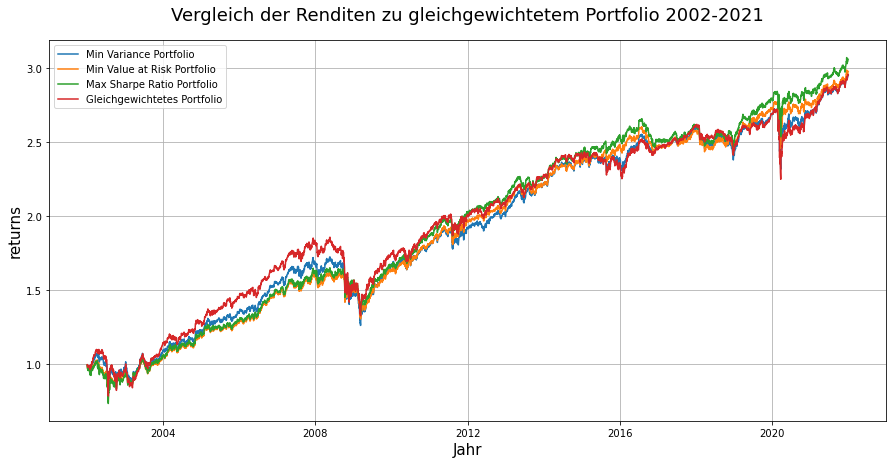

In [33]:
# Plot der vier BaH Portfolios
plt.figure(figsize=(15,7))
plt.plot(BaH_min_variance['Strategy Equity'], label = 'Min Variance Portfolio')
plt.plot(BaH_min_VaR['Strategy Equity'], label = 'Min Value at Risk Portfolio')
plt.plot(BaH_max_SharpeRatio['Strategy Equity'], label = 'Max Sharpe Ratio Portfolio')
plt.plot(BaH_eq_weights['Strategy Equity'], label = 'Gleichgewichtetes Portfolio')
plt.title('Vergleich der Renditen zu gleichgewichtetem Portfolio 2002-2021', fontsize = 18, va = 'center', y = 1.05)
plt.xlabel('Jahr', fontsize = 15)
plt.ylabel('returns', fontsize = 15)
plt.grid()
plt.legend();

**Beschreibung:**

Hierbei wird nun der Verlauf der kummulierten Renditen des gleichgewichtetes Portfolio der selben Aktien als Benchmark herangezogen.
<br>
Es wird ersichtlich, dass das gleichgewichtete Portfolio sehr ähnlich zu den anderen Portfolios performt und sogar minimal besser als das Min Variance Portfolio abschneidet.

Bis kurz vor der Finanzkrise 2008 kann es sich sogar deutlich von den anderen abheben. Wenn es jedoch zu Einbrüchen kommt wird auch erkennbar, dass die kummulierte Rendite des gleichgewichteten Portfolios stärker sinkt als bei den unterschiedlich gewichteten Varianten. Bei dem erneuten positiven Anstieg zeigt sich wieder eine stärkere Erholung. Der nächste äußerst starke Einbruch findet erst wieder 2020 statt. Somit kann darauf geschlossen werden, dass es über einen langen positiven Trend besser abschneiden würde als die definierten Portfolios. Seine größere Anfälligkeit für Krisen aber letztendlich dafür sorgt, dass es diese Performance nicht halten kann und die Portfolios mit den optimalen Gewichten der Benchmark überlegen sind.

# 5. Portfolios mit min. Varianz, min. VaR und max. Sharpe Ratio (2017-2021)

Aufgabenstellung: Berechnen Sie die Portfolios mit der minimalen Varianz, dem minimalen VaR und der 
maximalen Sharpe Ratio nun für den Zeitraum von 2017-2021 und vergleichen Sie die 
Portfoliogewichte mit den Ihren.

In [34]:
# Testdatensatz auf den gekürzten Zeitraum von 2017/01/01 - 2021/12/31 begrenzen
outsample_shorted = outsample.loc['2017-01-01':'2021-12-31']

In [35]:
# Berechnung der Varianz-Covarianz-Matrix und mitteleren Renditen; alpha-Quantil, Zeithorizont und risikoloser Zins wie vorher (siehe 1.2 & 1.3)
outsample_shorted_cov = outsample_shorted.cov()
outsample_shorted_mean_returns = outsample_shorted.mean()

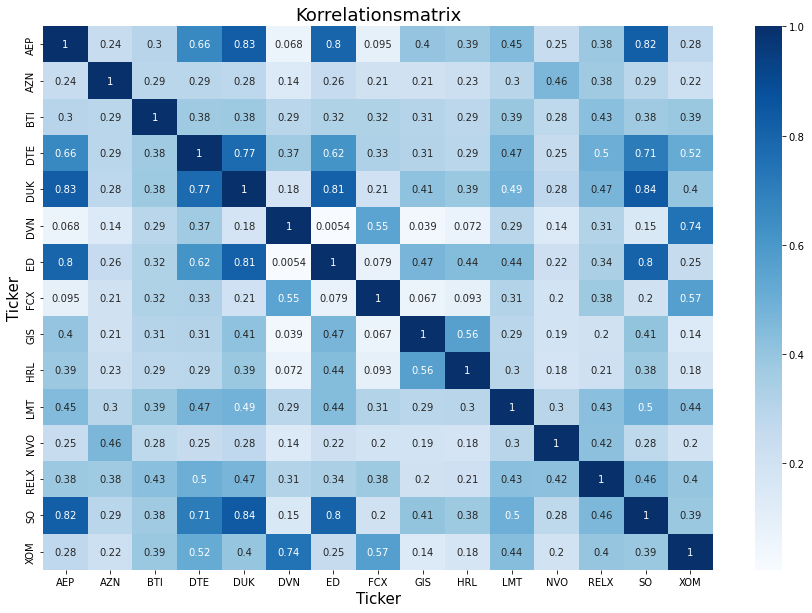

In [36]:
# Bilde die Correlationsmatrix der AKtien für 2017-2021
plt.figure(figsize=(15,10))
sns.heatmap(outsample_shorted.corr(), cmap="Blues", annot=True)
plt.title('Korrelationsmatrix', fontsize = 18)
plt.xlabel('Ticker', fontsize = 15)
plt.ylabel('Ticker', fontsize = 15);

**Beschreibung:**

Für den Zeitraum 2017-2021 sind die Korrelationen der Aktien des Portfolios höher als im Zeitraum 1997-2001. Ursache hierfür ist unteranderem, dass sich die Märkte oder die Branchen der ausgewählten Titel immer stärker miteinander verbunden haben. Durch die zunehmende Globalisierung und der Verbreitung von Informationen und Technologie kann es sein, dass sich Aktien aus unterschiedlichen Branchen und Ländern immer stärker beeinflussen. Zudem ist in dieser Zeitreihe auch der Wirtschaftsabschwung bedingt durch die Corona-Pandemie erfasst. Viele Unternehmen reagierten ähnlich auf die Auswirkungen der Pandemie, was zu einem Anstieg der Korrelation führte. <br>
Gedanken über ein Resampling der Titel des Portfolios könnten an dieser Stelle sinnvoll sein, um den ursprünglich gewünschten Zustand einer geringen Korrelation der Aktien untereinander wiederherzustellen. Eine geringe Kovarianz führt in der Regel auch zu einer geringen Korrelation und somit zu einer größeren Sicherheit gegenüber Marktrisiken.

### 5.1 Bestimmung des Portfolios mit minimaler Varianz (2017-2021)

In [37]:
# Ausführen der Funktionen aus Kapitel 1.1
function_result = min_variance(outsample_shorted_cov)

# Ergebnisse der Optimierung in DataFrame abspeichern
outsample_shorted_min_port_variance = pd.DataFrame([round(x,2) for x in function_result['x']], index=tickers).T
outsample_shorted_min_port_variance['Function Result'] = function_result['fun']

In [38]:
# Berechnung der weiteren Kennzahlen Rendite, Standardabweichung, Sharpe Ratio, Value at Risk für das min_variance_portfolio 2017-2021
outsample_shorted_min_port_variance1 = outsample_shorted_min_port_variance.drop(columns = ['Function Result'], axis = 1)
outsample_shorted_min_port_variance_weights = pd.DataFrame([round(x,6) for x in function_result['x']], index=tickers).T
weights4 = np.array(outsample_shorted_min_port_variance_weights.iloc[0])
portfolio_return, portfolio_std, portfolio_VaR, sharpe_ratio = calc_portfolio_perf(weights4, outsample_shorted_mean_returns, outsample_shorted_cov, alpha, days)
add_values(outsample_shorted_min_port_variance1)
outsample_shorted_min_port_variance1.index = ['Min Variance 2017-2021']

### 5.2 Bestimmung des Portfolios mit minimalem Value at Risk (VaR) (2017-2021)

In [39]:
# Ausführen der Funktionen aus Kapitel 1.2
function_result = min_VaR(outsample_shorted_mean_returns, outsample_shorted_cov, alpha, days)

# Ergebnisse der Optimierung in DataFrame abspeichern
outsample_shorted_min_port_VaR = pd.DataFrame([round(x,2) for x in function_result['x']], index=tickers).T
outsample_shorted_min_port_VaR['Function Result'] = function_result['fun']

In [40]:
# Berechnung der weiteren Kennzahlen Rendite, Standardabweichung, Sharpe Ratio, Value at Risk für das min_VaR_portfolio 2017-2021
outsample_shorted_min_port_VaR1 = outsample_shorted_min_port_VaR.drop(columns = ['Function Result'], axis = 1)
outsample_shorted_min_port_VaR_weights = pd.DataFrame([round(x,6) for x in function_result['x']], index=tickers).T
weights5 = np.array(outsample_shorted_min_port_VaR_weights.iloc[0])
portfolio_return, portfolio_std, portfolio_VaR, sharpe_ratio = calc_portfolio_perf(weights5, outsample_shorted_mean_returns, outsample_shorted_cov, alpha, days)
add_values(outsample_shorted_min_port_VaR1)
outsample_shorted_min_port_VaR1.index = ['Min VaR 2017-2021']

### 5.3 Bestimmung des Portfolios mit maximaler Sharpe Ratio (𝜇 - 𝜎 effizientes Portfolio) (2017-2021)

In [41]:
# Ausführen der Funktionen aus Kapitel 1.3
function_result = max_sharpe_ratio(outsample_shorted_mean_returns, outsample_shorted_cov, rf)

# Ergebnisse der Optimierung in DataFrame abspeichern
outsample_shorted_max_port_SharpeRatio = pd.DataFrame([round(x,2) for x in function_result['x']], index=tickers).T
outsample_shorted_max_port_SharpeRatio['Function Result'] = -function_result['fun']

In [42]:
# Berechnung der weiteren Kennzahlen Rendite, Standardabweichung, Sharpe Ratio, Value at Risk für das max_sharpeRatio_portfolio 2017-2021
outsample_shorted_max_port_SharpeRatio1 = outsample_shorted_max_port_SharpeRatio.drop(columns = ['Function Result'], axis = 1)
outsample_shorted_max_port_SharpeRatio_weights = pd.DataFrame([round(x,6) for x in function_result['x']], index=tickers).T
weights6 = np.array(outsample_shorted_max_port_SharpeRatio_weights.iloc[0])
portfolio_return, portfolio_std, portfolio_VaR, sharpe_ratio = calc_portfolio_perf(weights6, outsample_shorted_mean_returns, outsample_shorted_cov, alpha, days)
add_values(outsample_shorted_max_port_SharpeRatio1)
outsample_shorted_max_port_SharpeRatio1.index = ['Min VaR 2017-2021']

### 5.4 Vergleich der optimalen Gewichte für die drei Strategien  von 1997-2001 und 2017-2021

In [43]:
# Zusammenfassung der Portfolios von 2017-2021 in einem DataFrame
outsample_portfolios = pd.concat([outsample_shorted_min_port_variance1, outsample_shorted_min_port_VaR1, outsample_shorted_max_port_SharpeRatio1], axis=0)
outsample_portfolios.index = ['Min Variance (2017-2021)', 'Min VaR (2017-2021)', 'Max Sharpe Ratio (2017-2021)']

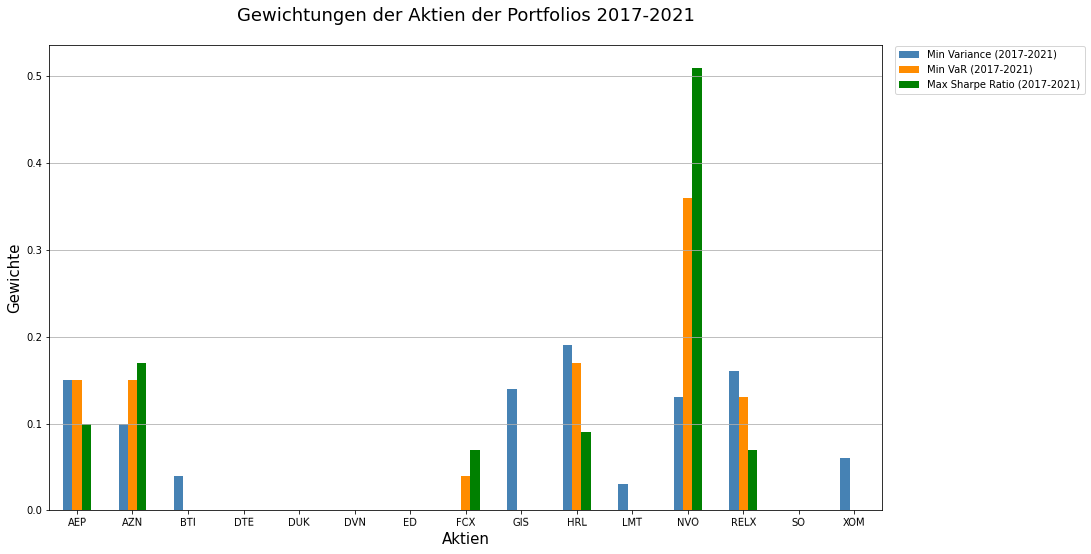

In [44]:
# Graphische Darstellung der Gewichtung der einzelnen Aktien in den drei definierten Portfolios 2017-2021
outsample_portfolios_weights = outsample_portfolios.drop(columns = ['Annual Return','Annual Variance', 'Value at Risk', 'Sharpe Ratio'], axis = 1)

# Plot der Gewichtungen der Aktien in verschiedenen Portfolios 2017-2021
ax = outsample_portfolios_weights.T.plot.bar( rot=1, figsize=(15, 7),color=['steelblue', 'darkorange', 'green'])
ax.legend(bbox_to_anchor=(1.01, 1.01), loc='upper left')
plt.tight_layout()
plt.grid(axis = 'y')
plt.xlabel('Aktien', fontsize = 15)
plt.ylabel('Gewichte', fontsize = 15)
plt.title('Gewichtungen der Aktien der Portfolios 2017-2021', fontsize = 18, va = 'center', y = 1.05);
plt.show;

**Beschreibung:**

Aus der Verteilung der Gewichte der neubestimmten Portfolios für den Zeitraum 2017-2021 sind Unterschiede zu den Portfolios aus 1.4 erkennbar.<br>

Die Aktie mit dem größten Einzelanteil in einem Portfolio ist Novo Nordisk (NVO) mit über 50% im Max Sharpe Ratio Portfolio. Im Min VaR Portfolio ist sie immerhin noch mit knapp 45% einbezogen. Im Min Variance Portfolio hingegen nur zu 13%.<br>

Aus den oben bereits erwähnten Gründen sind das Min VaR und das Max Sharpe Ratio Portfolio wieder sehr ähnlich gewichtet. <br>

Die Verteilung der Gewichte auf lediglich einige wenige Titel ist nun aber deutlich stärker ausgeprägt.
Das Min Variance Portfolio investiert nur in 10 der 15 Titel. Bei Max Sharpe Ratio und Min VaR sind lediglich 6 von 15 Aktien gewichtet worden. Ursache hierfür ist die Veränderung der Unternehmen und der Märkte. Der Anstieg der Korrelationskoeffizienten zeigt dies auch deutlich. Bei einem Betrachtungszeitraum von lediglich 5 Jahren und basierend auf aktuelleren Daten fallen einige Titel aus der Auswahl für die Bestimmung der optimalen Portfolios, da sie sich in den letzten Jahren schlechter als andere Aktien entwickelt haben und somit als nicht mehr so geeignet für das Portfolio gelten.

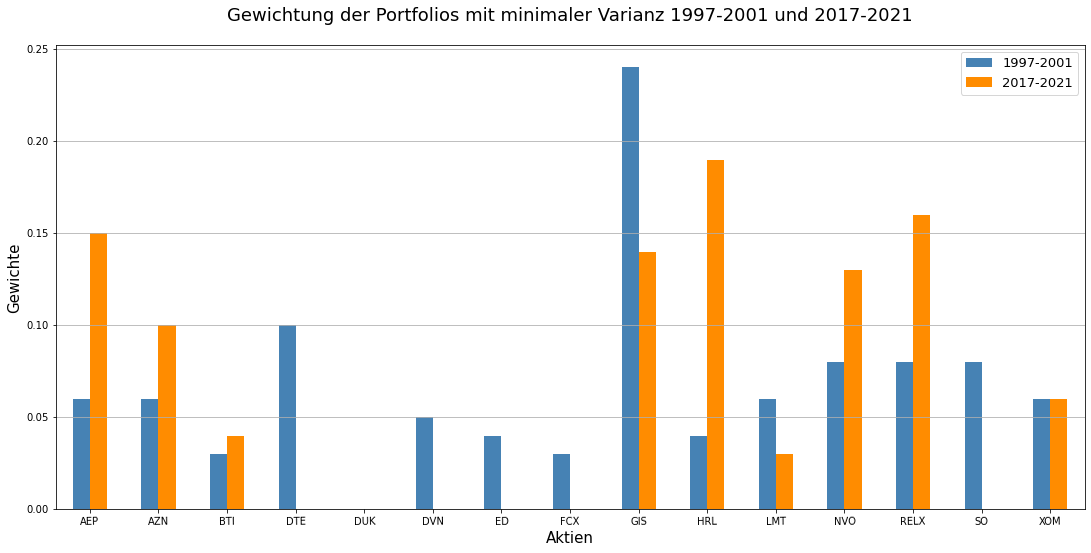

In [61]:
# Erstellung einen Dataframe welcher die Gewichte der min_variance_portfolios von 1997-2001 und 2017-2021 in einem Dataframe bündelt
min_variance_compared = pd.DataFrame().assign(insample = insample_weights.iloc[0], outsample =outsample_portfolios_weights.iloc[0])

# Funktion mit deren Hilfe ein grafischer Vergleich von Portfoliogewichten möglich ist
def compare(compared):
    ax = compared.plot.bar( rot=1, figsize=(15, 7),color=['steelblue', 'darkorange'])
    ax.legend(bbox_to_anchor=(1.01, 1.01), loc='upper left')
    ax.legend(labels=('1997-2001', '2017-2021'), fontsize = 13)
    plt.tight_layout()
    plt.grid(axis = 'y')
    plt.xlabel('Aktien', fontsize = 15)
    plt.ylabel('Gewichte', fontsize = 15)
    plt.show;

# Graphischer Vergleich
compare(min_variance_compared)
plt.title('Gewichtung der Portfolios mit minimaler Varianz 1997-2001 und 2017-2021', fontsize = 18, va = 'center', y = 1.05);

**Beschreibung:**

In den Portfolios mit minimaler Varianz sind die Gewichte noch auf die höchste Anzahl an Aktien in den Portfolios verteilt.
Im Vergleich zum Zeitraum 1997-2001 (14) sind jedoch auch 2017-2021 (10) bereits deutlich weniger Aktien für die Strategie gewichtet worden.<br>
Die Aktie mit dem höchsten Anteil im Portfolio wechselte von General Mills (GIS) zu Hormel (HRL). Ein Zeichen dafür, dass es in der Zeitspanne von 16 Jahren einige Veränderungen in den Unternehmen und den Märkten gab.

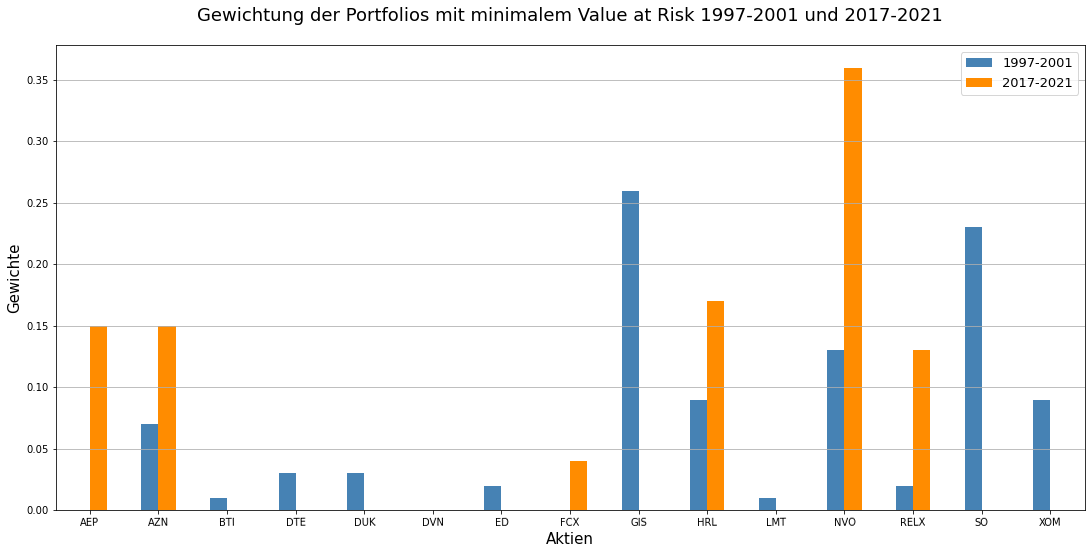

In [62]:
# Erstellung eines Dataframe welcher die Gewichte der min_VaR_portfolios von 1997-2001 und 2017-2021 in einem Dataframe bündelt
min_VaR_compared = pd.DataFrame().assign(insample = insample_weights.iloc[1], outsample = outsample_portfolios_weights.iloc[1])

# Graphischer Vergleich
compare(min_VaR_compared)
plt.title('Gewichtung der Portfolios mit minimalem Value at Risk 1997-2001 und 2017-2021', fontsize = 18, va = 'center', y = 1.05);

**Beschreibung:**

In den Portfolios mit minimalem Value at Risk ist die Zahl der gewichteten Aktien bereits stark zurückgegangen.
Im Vergleich zum Zeitraum 1997-2001 (12) sind  2017-2021 (6) nur noch sehr wenig Titel gewichtet worden.
Dies birgt das Risiko, dass die Performance des Gesamtportfolios nur noch durch die Performance einiger weniger Aktien gelenkt wird. <br>
Die Aktie mit dem höchsten Anteil im Portfolio wechselte von General Mills (GIS) zu Novo Nordisk (NVO).

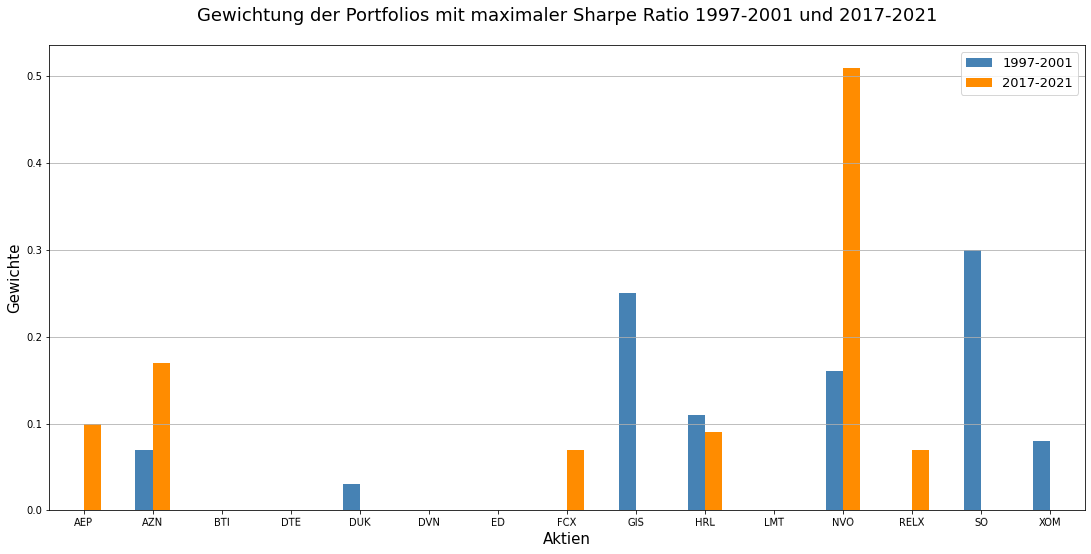

In [63]:
# Erstellung eines Dataframe welcher die Gewichte der max_sharpeRatio_portfolios von 1997-2001 und 2017-2021 in einem Dataframe bündelt
max_sharpeRatio_compared = pd.DataFrame().assign(insample = insample_weights.iloc[2], outsample = outsample_portfolios_weights.iloc[2])

compare(max_sharpeRatio_compared)
plt.title('Gewichtung der Portfolios mit maximaler Sharpe Ratio 1997-2001 und 2017-2021', fontsize = 18, va = 'center', y = 1.05);

**Beschreibung:**

In den Portfolios mit maximaler Sharpe Ratio ist die Zahl der gewichteten Aktien auch zurückgegangen.
Im Vergleich zum Zeitraum 1997-2001 (7) sind  2017-2021 (6) ist dies aber der geringste Rückgang.
Die durch numerische Optimierung bestimmten Gewichte des Portfolios sorgen dafür, dass weniger als die Hälfte der ausgewählten Aktien überhaupt im Portfolio verwendet werden. <br>
Die Aktie mit dem höchsten Anteil im Portfolio wechselte von Southern Company (SO) zu Novo Nordisk (NVO).

In [48]:
# Vergleich der Funktionswerte der Portfolios von 1997-2001 für 2002-2021 und 2017-2021 
parallel(df2,outsample_portfolios.iloc[:, : 4])

,Annual Return,Annual Variance,Value at Risk,Sharpe Ratio
Min Variance (2002-2021),0.097154,0.155069,0.157911,0.626523
Min VaR (2002-2021),0.099953,0.147464,0.142603,0.677815
Max Sharpe Ratio (2002-2021),0.102592,0.148510,0.141686,0.690806
,Annual Return,Annual Variance,Value at Risk,Sharpe Ratio
Min Variance (2017-2021),0.113624,0.148772,0.131084,0.763745
Min VaR (2017-2021),0.176001,0.164763,0.095010,1.068207
Max Sharpe Ratio (2017-2021),0.201280,0.184215,0.101726,1.092640


**Beschreibung:**

Vergleicht man nun die Werte der beiden Portfolios ist zu erkennen, dass die Portfolios (2017-2021) der rechten Seite deutlich besser abschneiden. Die annualisierten Renditen und die Sharpe Ratio sind beträchtlich höher und die Werte der annualisierten Varianz und des Value at Risk niedriger. 
Dies ist dadurch begründet, dass die Performance der Portfolios von 2002-2021 auf den berechneten Gewichten von 1997-2001 basiert. Im Laufe der Zeit sind die Gewichte der Portfolios nicht mehr optimal ausgerichtet, da sich die Unternehmen selbst, aber auch Branchen und Märkte wandeln. Die Portfolios von 2017-2021 können sozusagen als Rebalancing der 'alten Portfolios' angesehen werden und erzielen wieder eine bessere Performance.

# 6 Verbesserungsmöglichkeiten der Strategien

Aufgabenstellung: Wie würden Sie die Implementierung Ihrer Portfoliostrategie noch verbessern? Was 
könnten Sie noch beachten?

**Beschreibung:**

Die Buy-and-Hold-Strategie ist eine bekannte Anlagestrategie, die darauf abzielt, langfristig eine solide Rendite zu erzielen, indem man in Unternehmen investiert und diese über einen längeren Zeitraum hält. Um die Implementierung dieser Strategie zu verbessern, gibt es jedoch einige Aspekte, die in Betracht gezogen werden sollten.<br>

Eine Möglichkeit die Implementierung zu verbessern, besteht darin, **mehrere Asset-Klassen** in das Portfolio aufzunehmen. Dies ermöglicht es, das Risiko durch Diversifikation zu minimieren und die Renditechancen zu maximieren. Eine Methode, dies umzusetzen, ist die Auswahl von Assets mit minimaler Covarianz, um sicherzustellen, dass die verschiedenen Teile des Portfolios nicht stark miteinander korrelieren. Hierbei können beispielsweise Staatsanleihen verwendet werden.

Ein weiterer Ansatz könnte sein, ein **anderes alpha-Quantil** bei der Minimierung des Value-at-Risk (VaR) zu verwenden. Dies kann dazu beitragen, das Risiko weiter zu reduzieren, indem man sich auf die schlechtesten Fälle konzentriert. Ein niedrigeres Alpha-Quantil führt zu einem niedrigeren VaR. Dabei müssen die Auswirkungen auf das Gesamtrisiko des Portfolios berücksichtigt werden.

Statt der Standardabweichung kann man auch die **Semi-Varianz oder den Downside-Risk** verwenden, um das Risiko besser zu quantifizieren. Diese Metriken berücksichtigen nur die Verluste und ignorieren die Gewinne. Außerdem ist eine weitere Möglichkeit die Implementierung zu verbessern, die Verwendung der **Sortino-Ratio** anstelle der Sharpe-Ratio zu berücksichtigen, da sie nur negative Abweichungen berücksichtigt und somit eine präzisere Messung des Risikos liefert. Sie ist das Verhältnis von erwarteter Rendite zur Semivarianz. Dadurch lässt sich die Risiko-Rendite-Charakteristik einer Anlage bewerten.

Für kurze Prognosehorizonte kann es sinnvoll sein, eine **Mean Reversion** und für lange Prognosehorizonte eine **Moving Average Crossover-Strategie** anstelle einer Buy-and-Hold-Strategie zu verwenden, um von kurzfristigen/mittelfristigen Marktschwankungen zu profitieren. Die Mean Reversion-Strategie basiert auf der Annahme, dass die Kurse von Wertpapieren auf lange Sicht tendenziell zu ihrem Durchschnittswert zurückkehren. Diese Strategie nutzt die Abweichungen von diesem Durchschnittswert aus, um Gewinne zu erzielen, indem sie in Wertpapiere investiert, deren Kurse unter ihrem Durchschnittswert liegen und sie verkauft, wenn sie wieder ihrem Durchschnittswert entsprechen.
Die Moving Average Crossover-Strategie nutzt gleitende Durchschnitte, um Trends zu erkennen. Dabei wird ein kürzerer gleitender Durchschnitt und ein längerer gleitender Durchschnitt verwendet. Wenn der kürzere gleitende Durchschnitt den längeren überschreitet, wird dies als Kaufsignal gesehen und umgekehrt. Diese Strategie nutzt die Annahme, dass ein kürzerer gleitender Durchschnitt schneller auf Marktveränderungen reagiert und dass ein Crossover zwischen den beiden gleitenden Durchschnitten ein frühes Signal für einen Trendwechsel darstellen kann.
Jedoch sind diese beiden Strategien mit Transaktionskosten verbunden, die bei jeder Änderung des Portfolios entrichtet werden müssen.

Abschließend ist es wichtig das Portfolio regelmäßig zu **rebalancieren** (sonst zu starke Abweichung der realen Gewichte von den optimalen Gewichten), um sicherzustellen, dass die Gewichtungen der verschiedenen Teile des Portfolios immer den Zielen entsprechen und somit das Risiko  reduzieren und die Renditechancen maximieren.
Es ist jedoch zu beachten, dass die Auswahl der passenden Portfolio-Strategie von den individuellen Zielen, Risikotoleranz und Finanzsituation des Investorsabhängt und daher eine gründliche Analyse und Beratung durch Finanzexperten von Nöten ist.


Eine weitere Möglichkeit, die Implementierung der Buy-and-Hold-Strategie zu verbessern, kann die Berücksichtigung von **Quantitativen Faktoren** sein, wie zum Beispiel statistischen Arbitrage oder die Verwendung von Machine-Learning-Methoden (𝜇 und 𝜎 nicht auf Basis historischer Daten schätzen), um die Auswahl der Aktien zu optimieren.


Insgesamt gibt es viele Möglichkeiten, die Implementierung einer Buy-and-Hold-Strategie zu verbessern, und es ist wichtig, die individuellen Ziele, Risikotoleranz und Finanzsituation des Investors zu berücksichtigen, um die beste Strategie zu entwickeln.

# MA-Alternative 1:
# 7.1 Momentum-Strategie

Aufgabenstellung MA-Alternative 1: Entwickeln Sie für Ihre 15 Aktien eine Momentum Strategie auf Monatsebene. Diese ist wie folgt aufgebaut: Sie investieren in das Terzil der Unternehmen mit der 
höchsten Rendite des Vormonats. Diese 5 Unternehmen halten Sie bis zum Ende des darauffolgenden Monats. Zum Monatsende erfolgt somit immer eine Portfolioumschichtung, wobei die 
Unternehmen mit der höchsten Rendite im vergangen Monat gekauft werden. Funktioniert 
diese Strategie? Beurteilen Sie die Performance.

In [49]:
# Monatliche Logreturns berechnen
monthly_returns = returns.resample('M').sum()

In [50]:
# helper functions
def monthly_weights(monthly_returns):
    empty_list = list()
    for i in range(len(monthly_returns.iloc[3:])): #ersten optimalen Gewichte am Ende des 4. Monats (hier: April)
        # Top5 Aktien mit den höchsten Returns im aktuellen Monat bestimmen
        current_month_returns = np.array(monthly_returns.iloc[i+3]) #erster Wert Ende April
        sort_index = np.argsort(current_month_returns)
        locations = sort_index[-5:].tolist()
        tickers_top5 = [tickers[i] for i in locations]
        # Returns DF auf die letzten vier Monate und die Top5 Aktien zuschneiden sowie die entsprechende Cov-Matrix berechnen
        monthly_top5_returns = returns[tickers_top5].loc[str(monthly_returns.index.tolist()[i])[0:10]:str(monthly_returns.index.tolist()[i+3])[0:10]]
        monthly_top5_mean_returns = monthly_top5_returns.mean()
        monthly_top5_cov = monthly_top5_returns.cov()
        # Funktion zur Bestimmung des Portfolios mit maximaler Sharpe Ratio ausführen auf Basisi der letzten 4 Monate (window ca. 120 Tage)
        weights_top5 = max_sharpe_ratio(monthly_top5_mean_returns, monthly_top5_cov, rf).x #(Fkt. aus Kapitel 1.3)
        # Array mit 15 Gewichten erstellen; die optimalen Gewichte der monatl. Top5 hinzufügen und Array an Liste anhängen
        weights = np.zeros(len(tickers))
        weights[locations] = weights_top5
        empty_list.append(weights)
    # DataFrame mit den monatlichen Gewichten beginnend nach 2 Monaten erstellen
    weights_df = pd.DataFrame(empty_list, columns=tickers)
    weights_df.index = monthly_returns.index[3:] #Index beginnt ab dem 4. Monat
    return weights_df

# monthly sharpe ratio
monthly_sr = lambda x: x.mean() / x.std()

# Strategy (main function)
def momentum_strategy(monthly_returns):
    # helper function monthly_weights ausführen und als DataFrame abspeichern
    monthly_weights_df = monthly_weights(monthly_returns)
    # DataFrame monthly_returns einen Monat nach DataFrame monthly_weights beginnen lassen
    monthly_returns = monthly_returns.iloc[5:] #erster Return im 6. Monat (Juni) mit den Gewichten aus 4. & 5. Monat (April, Mai)
    # DataFrame für Returns und Sharpe Ratio erstellen
    empty_list = list()
    # Monatiliche Returns mit den halbierten Gewichten der Top5 Aktien vom letzten und vorletzten Monat multiplizieren
    for i in range(len(monthly_returns)):
        weighted_current_month_returns = monthly_returns.iloc[i] * (monthly_weights_df.iloc[i] + monthly_weights_df.iloc[i+1]) / 2
        empty_list.append(weighted_current_month_returns)
    # DataFrame mit den monatlichen gewichteten Returns pro Aktie erstellen
    momentum_strategy_returns = pd.DataFrame(empty_list, columns=tickers)
    momentum_strategy_returns.index = monthly_returns.index
    # Erstellen der Spalten 'Strategy' und 'Strategy Equity' und Berechnung der Sharpe Ratio
    momentum_strategy_returns['Strategy'] = np.sum(momentum_strategy_returns, axis=1)
    momentum_strategy_returns['Strategy Equity'] = momentum_strategy_returns['Strategy'].cumsum() + 1
    ann_sharpe_ratio = monthly_sr(momentum_strategy_returns['Strategy']) * np.sqrt(12)
    return ann_sharpe_ratio, momentum_strategy_returns

momentum_strategy_sr, momentum_strategy_returns = momentum_strategy(monthly_returns)

Die Sharpe Ratio der Momentum Strategie liegt bei 0.75 p.a.
Der kumulierte Return der Momentum Strategie liegt bei 3.96
Der annualisierte Return der Momentum Strategie liegt bei 0.12 p.a.


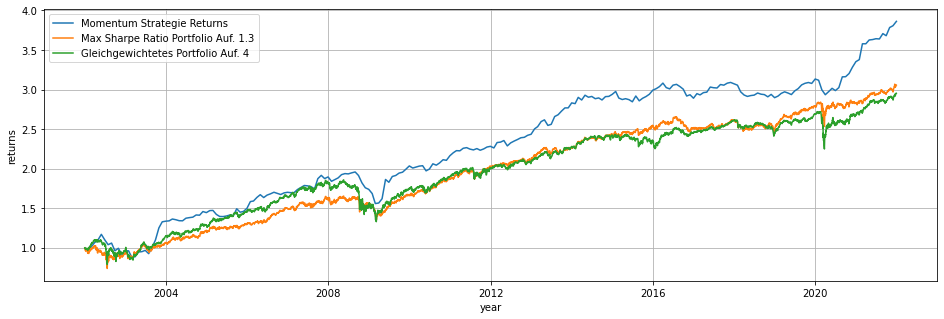

In [51]:
# Ausgabe der annualisierten Sharpe Ratio, kumulierten Returns und annualisierten Returns
print("Die Sharpe Ratio der Momentum Strategie liegt bei %s p.a." % (np.round(momentum_strategy_sr,2)))
print("Der kumulierte Return der Momentum Strategie liegt bei %s" % (np.round(momentum_strategy_returns['Strategy Equity'][-1],2)))
print("Der annualisierte Return der Momentum Strategie liegt bei %s p.a." % (np.round(momentum_strategy_returns['Strategy'].mean() * 12,2)))

# Vergleich der Returns der Momentum Strategie, Max Sharpe Ratio (Auf. 1) und gleichgewichtetes Portfolio (Auf. 4)
plt.figure(figsize=(16,5))
plt.plot(momentum_strategy_returns['Strategy'].loc['2002-01-01':].cumsum()+1,  label='Momentum Strategie Returns')
plt.plot(BaH_max_SharpeRatio['Strategy Equity'], label='Max Sharpe Ratio Portfolio Auf. 1.3')
plt.plot(BaH_eq_weights['Strategy Equity'], label='Gleichgewichtetes Portfolio Auf. 4')
plt.xlabel('year')
plt.ylabel('returns')
plt.grid()
plt.legend();

Die Strategie basiert auf Momentum (past winner = future winner) unter der Annahme, dass der letzte Monat Prognosekraft für nächsten zwei Monate besitzt. Das implementierte Rebalancing verhindert eine zu große Differenz zwischen realen und optimalen Gewichtungen, verursacht jedoch regelmäßige Transaktionskosten, wodurch Brutto Renditen entstehen. Durch die monatliche Frequenz des Rebalancing sind die Transaktionskosten allerdings annehmbar.

Im Vergleich zum besten Portfolio (Max Sharpe Ratio) der BaH-Strategien aus Aufgabe 2 und dem gleichgewichteten Portfolio über denselben Zeitraum, schneidet die Momentum Strategie brutto deutlich besser ab. Nicht verwunderlich ist hierbei, dass es die BaH-Strategien besonders in anhaltenden steigenden Trends outperformt, da sie auf Momentum setzt. Auch während der Corona Krise scheint die Strategie deutlich besser zu performen und kann insobesondere von einem starken Aufstieg in der Erholungsphase profitieren.

Mit den niedrigen Werten der annualisierten Sharpe Ratio und des annualisierten Returns ist diese Strategie dennoch nicht zu empfehlen.

### Zum Abschluss noch einige Performanceindikatoren der Momentum Strategie:

In [52]:
#create columns that indicate whether each month return was positive, 
#negative or flat.
momentum_strategy_returns['win'] = (np.where(momentum_strategy_returns['Strategy'] > 0, 1,0)) 
momentum_strategy_returns['loss'] = (np.where(momentum_strategy_returns['Strategy'] < 0, 1,0)) 
momentum_strategy_returns['scratch'] = (np.where(momentum_strategy_returns['Strategy'] == 0, 1,0)) 

#create columns with a cumulative sum of each of the columns created above 
momentum_strategy_returns['wincum'] = (np.where(momentum_strategy_returns['Strategy'] > 0, 1,0)).cumsum() 
momentum_strategy_returns['losscum'] = (np.where(momentum_strategy_returns['Strategy'] < 0, 1,0)).cumsum() 
momentum_strategy_returns['scratchcum'] = (np.where(momentum_strategy_returns['Strategy'] == 0, 1,0)).cumsum() 

#create columns with hit ratio and loss ratio data 
momentum_strategy_returns['hitratio'] = momentum_strategy_returns['wincum'] / (momentum_strategy_returns['wincum']+momentum_strategy_returns['losscum']) 
momentum_strategy_returns['lossratio'] = 1 - momentum_strategy_returns['hitratio'] 

#create columns with rolling 12 month hit ratio and loss ratio data
momentum_strategy_returns['rollhitratio'] = momentum_strategy_returns['hitratio'].rolling(window=12).mean()
momentum_strategy_returns['rolllossratio'] = 1 - momentum_strategy_returns['rollhitratio'] 

#create column with rolling 1 year daily standard deviation and 
#rolling 1 year annualised standard deviation
momentum_strategy_returns['roll12mstdev'] = momentum_strategy_returns['Strategy'].rolling(window=12).std()
momentum_strategy_returns['roll12mannualisedvol'] = momentum_strategy_returns['roll12mstdev'] * np.sqrt(12)

Annualisierte Volatilität = 16.02%


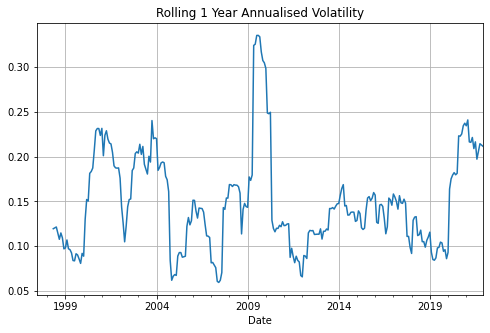

In [53]:
# Volatility
volmonthly = (momentum_strategy_returns['Strategy'].std()) * np.sqrt(12)
print ('Annualisierte Volatilität =',str(round(volmonthly,4)*100)+"%")

momentum_strategy_returns['roll12mannualisedvol'].plot(grid=True, figsize=(8,5),
title='Rolling 1 Year Annualised Volatility');

**Beschreibung:**

Die annualisierte rollierende Volatilität des erzeugten Aktienportfolios mit der Momentum Strategie schwankt ungefähr zwischen 0,25 und 0,05. Eine Volatilität von 25% bedeutet, dass der Wert des Portfolios in einem bestimmten Zeitraum im Durchschnitt um 25% pro Jahr geschwankt hat, was ein sehr hohes Risiko darstellt. Eine Volatilität von 5% wäre hingegen ein niedrigeres Risiko. Eine annualisierte Volatilität von 16,02% für ein Portfolio bedeutet, dass die Wertschwankungen des Portfolios im Durchschnitt 16,02% des Gesamtwerts des Portfolios pro Jahr betragen. Dies ist ein hoher Wert. Vor allem im Zeitraum der Finanzkrise und der Coronapandemie ist ein deutlicher Anstieg der Volatilität erkennbar, da sich in dieser Zeit auch der Markt verändert hat.


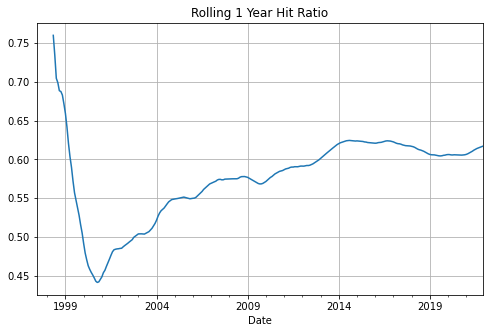

In [54]:
# Anteil der Monate mit positiver Rendite
momentum_strategy_returns['rollhitratio'].plot(grid=True, figsize=(8,5),
title='Rolling 1 Year Hit Ratio');

**Beschreibung:**

Der Anteil der Monate des Portfolios mit positiver Rendite, der sich zwischen 2014 und 2019 bei etwa 60% stabilisiert hat, deutet darauf hin, dass das Portfolio in einem relativ stabilen Zeitraum überwiegend positive Ergebnisse erzielt hat. Der sinkende Wert der rolling 1 year hit ratio unter 0,45 seit 1998 deutet darauf hin, dass die Wahrscheinlichkeit für positive Ergebnisse des Portfolios abgenommen hat. Für den Zeitraum von 2001 bis 2014 ist hingegen ein deutlich positiver Trend zu sehen. Ab 2002 werden mehr positive als negative Ergebnisse mit der Momentum Strategie erzielt, da der Wert der Hit Ratio über 0,5 liegt.

In [55]:
# Annualised Return; 'cagr' stands for compound, annualised gross return
days = (momentum_strategy_returns.index[-1] - momentum_strategy_returns.index[0]).days
cagr = ((((momentum_strategy_returns['Strategy Equity'][-1]) / momentum_strategy_returns['Strategy Equity'][1])) ** (365/days)) - 1
print ('CAGR =',str(round(cagr,3)*100)+"%")

CAGR = 5.7%


In [56]:
# Return der letzten 12 Monate
momentum_strategy_returns['last12mret'] = momentum_strategy_returns['Strategy'].rolling(window=12,center=False).sum()
last12mret = momentum_strategy_returns['last12mret'][-1]
print('last 12 month return =',str(round(last12mret*100,2))+"%")

last 12 month return = 51.04%


In [57]:
# Max drawdown (MDD): Ist ein Maß für den größten Preisrückgang von einem Höchststand zu einem Tiefststand.
# Erstellung der max drawdown Funktion
def max_drawdown(X):
    mdd = 0
    peak = X[0]
    for x in X:
        if x > peak:
            peak = x
        dd = (peak - x) / peak
        if dd > mdd:
            mdd = dd
    return mdd

mdd_monthly = max_drawdown(momentum_strategy_returns['Strategy Equity'])
print ('max drawdown =',str(round(mdd_monthly,4)*100)+"%")

max drawdown = 35.94%


In [58]:
# Best Month Performance
bestmonth = max(momentum_strategy_returns['Strategy'])
print ('Best month =',str(round(bestmonth,2)*100)+"%")
print ('Date =',str(momentum_strategy_returns['Strategy'].idxmax())[0:10])

Best month = 24.0%
Date = 2009-05-31


In [59]:
# Worst Month Performance
worstmonth = min(momentum_strategy_returns['Strategy'])
print ('Worst month =',str(round(worstmonth,2)*100)+"%")
print ('Date =',str(momentum_strategy_returns['Strategy'].idxmin())[0:10])

Worst month = -13.0%
Date = 2009-02-28


In [60]:
# % of Profitable Months & % Non-Profitable Months
positive_months = len(momentum_strategy_returns['Strategy'][momentum_strategy_returns['Strategy'] > 0])
negative_months = len(momentum_strategy_returns['Strategy'][momentum_strategy_returns['Strategy'] < 0])
flatmonths = len(momentum_strategy_returns['Strategy'][momentum_strategy_returns['Strategy'] == 0])
perc_positive_months = positive_months / (positive_months + negative_months + flatmonths)
perc_negative_months = negative_months / (positive_months + negative_months + flatmonths)
print ('% of Profitable Months =',str(round(perc_positive_months,2)*100)+"%")
print ('% of Non-profitable Months =',str(round(perc_negative_months,2)*100)+"%")

% of Profitable Months = 62.0%
% of Non-profitable Months = 38.0%
